#**YOLO v1 from Scratch**

**If you’re not already familiar** with YOLO v1, please **review the resources** below.

---
###Rescources:
* [Paper](https://arxiv.org/pdf/1506.02640)
* [Video Implementation](https://youtu.be/n9_XyCGr-MI?feature=shared )
* [Video Explanation](https://youtu.be/TPD9AfY7AHo?feature=shared)
---

####Getting the Data
Big thanks to Aladdin Persson for providing the dataset check you his [YouTube channel](https://youtube.com/@aladdinpersson?feature=shared) in your free time!

We will use the Pascal VOC Dataset

**ENSURE THAT YOU HAVE YOUR KAGGLE API INSTALLED!**

In [ ]:
!pip install opendatasets --q
import opendatasets as od
od.download('https://www.kaggle.com/datasets/aladdinpersson/pascalvoc-yolo', data_dir='YOLOv1_Dataset')

###Libraries

In [ ]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms

import torch.nn.functional as F
import torchvision.transforms.functional as FT

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
from tqdm.auto import tqdm

from collections import Counter    # Counter counts how many times each element appears, e.g., label frequencies for examples Counter(['cat', 'dog', 'cat']) -> {'cat': 2, 'dog': 1}

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image

import matplotlib.patches as patches  # patches supplies shape classes (Rectangle, Circle, etc.) for drawing boxes

import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.manual_seed(2)

##Utils

---

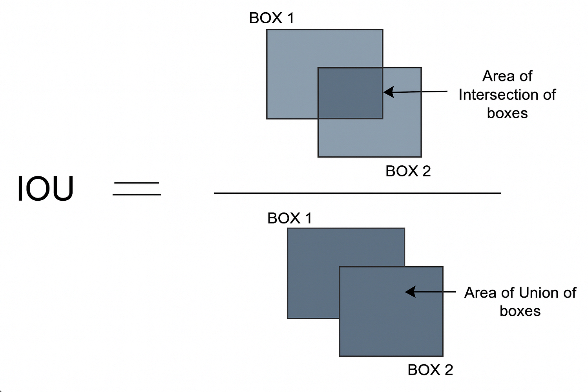

In [ ]:
# @title Calculating IOU
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        # Convert center-format predictions to corner coords
        # Use [..., 0:1] slicing to keep output shape (..., 1) for broadcasting
        # left   = x_center − (width / 2)
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        # top    = y_center − (height / 2)
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        # right  = x_center + (width / 2)
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        # bottom = y_center + (height / 2)
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        # Apply the same conversion for ground-truth boxes
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        # Predictions already in (x1, y1, x2, y2) format; unpack directly
        box1_x1 = boxes_preds[..., 0:1]  # left coordinate
        box1_y1 = boxes_preds[..., 1:2]  # top coordinate
        box1_x2 = boxes_preds[..., 2:3]  # right coordinate
        box1_y2 = boxes_preds[..., 3:4]  # bottom coordinate

        # Unpack ground-truth corner coords similarly
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # Determine coordinates of the intersection rectangle
    # x1 = max(left1, left2)
    x1 = torch.max(box1_x1, box2_x1)
    # y1 = max(top1, top2)
    y1 = torch.max(box1_y1, box2_y1)
    # x2 = min(right1, right2)
    x2 = torch.min(box1_x2, box2_x2)
    # y2 = min(bottom1, bottom2)
    y2 = torch.min(box1_y2, box2_y2)

    # Compute intersection width and height
    # (x2 - x1) might be negative if no overlap, clamp to zero
    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    # Intersection area = width × height
    intersection = inter_w * inter_h

    # Compute area of each box
    # (x2 - x1) × (y2 - y1), abs() guards against any reversed coords
    box1_area = ((box1_x2 - box1_x1) * (box1_y2 - box1_y1)).abs()
    box2_area = ((box2_x2 - box2_x1) * (box2_y2 - box2_y1)).abs()

    # IoU = intersection / (area1 + area2 − intersection)
    # Add a tiny epsilon to denominator to prevent division by zero
    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

---

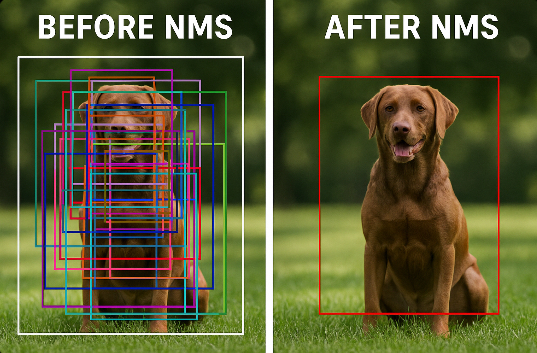

In [ ]:
# @title Non-Max Suppression
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="midpoint"):
    """
    Filters overlapping bounding boxes using Non-Maximum Suppression (NMS).

    Parameters:
        bboxes (list): List of boxes, each as [class, confidence, x, y, w, h].
        iou_threshold (float): Overlap threshold; discard boxes with IoU ≥ this value.
        threshold (float): Confidence cutoff; keep boxes with sigmoid(confidence) > threshold.
        box_format (str): Coordinate format, either "midpoint" (x_center, y_center, w, h)
                          or "corners" (x1, y1, x2, y2).

    Returns:
        list: Filtered list of bounding boxes after applying NMS.
    """

    assert type(bboxes) == list  # ensure we received a list of bounding boxes

    # filter out boxes with confidence ≤ threshold (apply sigmoid to raw scores)
    bboxes = [
        box
        for box in bboxes
        if torch.sigmoid(torch.tensor(box[1])).item() > threshold
    ]
    # sort remaining boxes by confidence score descending
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    bboxes_after_nms = []  # list to hold boxes kept after suppression

    # process until no boxes remain
    while bboxes:
        chosen_box = bboxes.pop(0)  # take the box with highest confidence

        # remove any box of the same class that has IoU ≥ iou_threshold with chosen_box
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),  # chosen box coordinates (x, y, w, h)
                torch.tensor(box[2:]),         # current box coordinates
                box_format=box_format,
            )
            < iou_threshold  # keep only if overlap is below the threshold
        ]

        bboxes_after_nms.append(chosen_box)  # retain the chosen box

    return bboxes_after_nms  # return list of filtered boxes

---

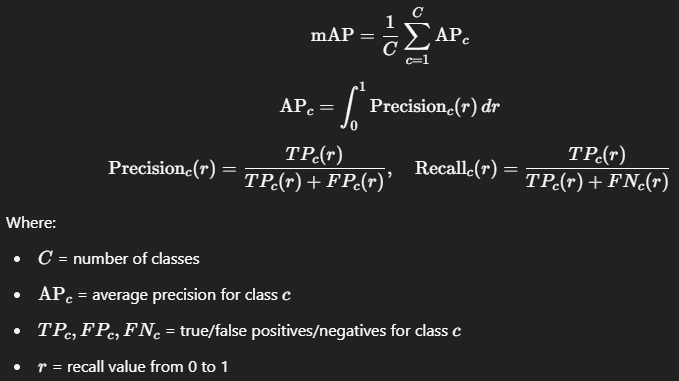

I know it looks SCARY, but it really isn't:

* [Video Explanation](https://youtu.be/TSMJ-QRnk54?feature=shared)

In [ ]:
# @title Calculating mAP
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Computes the mean Average Precision (mAP) over all object classes.

    Parameters:
        pred_boxes (list of lists):
            Each prediction as [img_idx, class_label, confidence_score, x, y, w, h].
        true_boxes (list of lists):
            Each ground-truth as [img_idx, class_label, x, y, w, h].
        iou_threshold (float):
            Minimum IoU required to count a detection as a true positive (default: 0.5).
        box_format (str):
            Coordinate format for boxes:
                - "midpoint": (x_center, y_center, width, height)
                - "corners":  (x1, y1, x2, y2)
        num_classes (int):
            Number of distinct classes to evaluate (default: 20).

    Returns:
        float: Mean of per-class Average Precision (AP) values, computed only for
               classes that have at least one ground-truth box.
    """

    # 1) Prepare to collect AP for each class
    average_precisions = []          # will store the AP of each class

    # 2) Small constant for numerical stability in divisions
    epsilon = 1e-6

    # 3) Loop over each class index
    for c in range(num_classes):
        detections = []              # predictions of class c
        ground_truths = []           # ground-truth boxes of class c

        # 3a) Filter predictions for class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        # 3b) Filter ground-truths for class c
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # 4) Count GT boxes per image: {img_idx: count}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # 4b) Convert counts to zero-tensors of corresponding length
        #     This tensor tracks which GT boxes have been matched
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # 5) Sort detections by confidence (index 2) descending
        detections.sort(key=lambda x: x[2], reverse=True)

        # 6) Initialize TP and FP arrays with zeros
        TP = torch.zeros(len(detections))  # True Positive flags
        FP = torch.zeros(len(detections))  # False Positive flags

        # 7) Total number of ground-truth boxes for this class
        total_true_bboxes = len(ground_truths)
        if total_true_bboxes == 0:
            continue  # skip class c if no ground-truths

        # 8) Evaluate each detection
        for detection_idx, detection in enumerate(detections):
            # 8a) Select GTs in the same image as this detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]
            best_iou = 0                # to track highest IoU for this detection
            best_gt_idx = None          # index of the best-matching GT box

            # 8b) Find the GT box with the highest IoU
            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),  # predicted box coords
                    torch.tensor(gt[3:]),         # GT box coords
                    box_format=box_format,
                )
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            # 8c) Determine True Positive vs False Positive
            if best_iou > iou_threshold:
                # if this specific GT has not yet been matched
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1                    # mark TP
                    amount_bboxes[detection[0]][best_gt_idx] = 1  # flag GT as matched
                else:
                    FP[detection_idx] = 1                    # duplicate detection → FP
            else:
                FP[detection_idx] = 1                        # IoU too low → FP

        # 9) Compute cumulative sums for precision–recall curve
        TP_cumsum = torch.cumsum(TP, dim=0)  # cumulative TP count
        FP_cumsum = torch.cumsum(FP, dim=0)  # cumulative FP count

        # 10) Build recall and precision arrays
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        # recall[k] = TP up to k / total ground-truths
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        # precision[k] = TP up to k / (TP + FP up to k)

        # 11) Prepend boundary point to anchor PR curve at the origin
        precisions = torch.cat((torch.tensor([1.0]), precisions))
        recalls = torch.cat((torch.tensor([0.0]), recalls))

        # 12) Compute Average Precision (AP) via trapezoidal rule
        #     torch.trapz(y, x) ≈ ∫ y dx using trapezoids between points
        average_precisions.append(torch.trapz(precisions, recalls))

    # 13) Return the mean of all per-class APs
    return sum(average_precisions) / len(average_precisions)

---

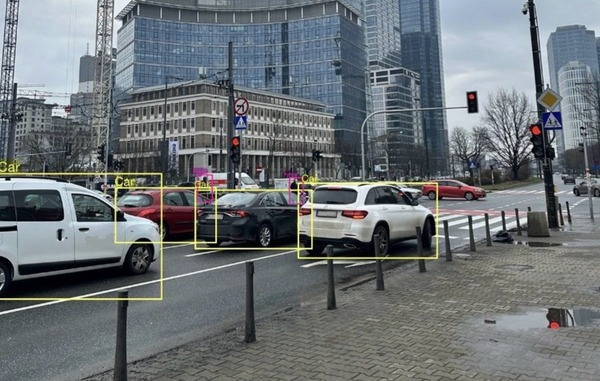

In [ ]:
# @title Bounding Boxes coordinates relative to Grid Cell → coordinates relative to Image
def convert_cellboxes(predictions, S=7):
    """
    Convert YOLO grid-cell–relative bounding boxes into image–relative coordinates.

    Parameters:
        predictions (torch.Tensor):
            Raw output of shape (batch_size, S*S*30) or reshaped to
            (batch_size, 7, 7, 30). For each grid cell it contains:
              - 20 class probabilities,
              - 2 confidence scores,
              - 2 sets of box coordinates (x, y, w, h).
        S (int):
            Number of grid cells per dimension (default: 7). Used to normalize
            and offset the (x, y) coordinates from cell space into full-image space.

    Returns:
        torch.Tensor:
            Tensor of shape (batch_size, 7, 7, 6), where each entry is:
              [predicted_class, best_confidence, x, y, width, height]
            with (x, y, width, height) normalized to [0, 1] over the whole image.
    """
    predictions = predictions.to('cpu')  # ensure tensor is on CPU for indexing
    batch_size = predictions.shape[0]    # number of images in the batch
    predictions = predictions.reshape(batch_size, 7, 7, 30)  # reshape to (batch, S, S, 30)

    bboxes1 = predictions[..., 21:25]  # first set of box coords (x, y, w, h) per cell
    bboxes2 = predictions[..., 26:30]  # second set of box coords per cell

    # stack the two confidence scores into a (2, batch, S, S) tensor
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0),
         predictions[..., 25].unsqueeze(0)),
        dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    # select predictor index (0 or 1) with higher confidence for each cell

    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    # choose coords from the best predictor per cell

    # create a tensor of cell x-indices, shape (batch, S, S, 1)
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)

    # convert cell-relative x-centers to image-relative:
    # add cell column index, then normalize by S
    x = 1 / S * (best_boxes[..., :1] + cell_indices)

    # convert cell-relative y-centers to image-relative:
    # add cell row index (permute indices for rows), then normalize by S
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))

    # normalize width and height by the number of cells
    w_y = 1 / S * best_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    # final bounding-box coords: (x_center, y_center, width, height)

    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    # choose class with highest probability from the first 20 entries

    best_confidence = torch.max(
        predictions[..., 20],
        predictions[..., 25]
    ).unsqueeze(-1)
    # take the higher of the two confidence scores per cell

    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes),
        dim=-1
    )  # assemble final output: [class, confidence, x, y, w, h]

    return converted_preds  # shape (batch, S, S, 6)

In [ ]:
# @title Convert Grid Cell Predictions to Per-Image Bounding Box Lists
def cellboxes_to_boxes(out, S=7):
    """
    Convert YOLO grid-cell predictions into per-image lists of bounding boxes.

    Parameters:
        out (torch.Tensor):
            Raw model output of shape (batch_size, S*S*30), where each cell predicts
            30 values (20 class scores, 2 confidences, 2×4 box coords).
        S (int):
            Number of grid cells per dimension (default: 7). Used to reshape and flatten.

    Returns:
        list of lists:
            Nested list [batch_size][S*S][6], where each inner list contains:
            [predicted_class (int), confidence (float), x (float), y (float), w (float), h (float)]
            with (x, y, w, h) in image-relative coordinates (normalized to [0,1]).
    """

    # Convert cell-based predictions to shape (batch, S*S, 6)
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    # Ensure class indices are integers
    converted_pred[..., 0] = converted_pred[..., 0].long()

    all_bboxes = []  # will hold each image’s list of boxes

    # Iterate over each image in the batch
    for ex_idx in range(out.shape[0]):
        bboxes = []
        # Iterate over each of the S*S cell predictions
        for bbox_idx in range(S * S):
            # Extract the six values and convert them to native Python types
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes  # return nested list of boxes per image

In [ ]:
# @title Extract and Postprocess Bounding Boxes for mAP Evaluation
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    """
    Extracts predicted and ground-truth bounding boxes from a DataLoader for mAP evaluation.

    Parameters:
        loader (DataLoader):
            Yields batches of (images, labels), where labels are in grid-cell format.
        model (torch.nn.Module):
            Trained YOLO model used for inference.
        iou_threshold (float):
            IoU cutoff for Non-Max Suppression; boxes with IoU ≥ this value are suppressed.
        threshold (float):
            Confidence threshold; only boxes with sigmoid(confidence) > threshold are kept.
        pred_format (str):
            Format of model predictions; default “cells” (grid-cell output).
        box_format (str):
            Format for bounding-box coordinates in IoU calculations:
              - "midpoint": (x_center, y_center, width, height)
              - "corners":  (x1, y1, x2, y2)
        device (str):
            Device for inference, e.g. "cuda" or "cpu".

    Returns:
        all_pred_boxes (list of lists):
            All predicted boxes across the dataset, each entry as
            [image_index, class, confidence, x, y, w, h].
        all_true_boxes (list of lists):
            All ground-truth boxes across the dataset, each entry as
            [image_index, class, confidence, x, y, w, h] (confidence from labels).
    """

    all_pred_boxes = []  # will collect [img_idx, ...predicted box] for every image
    all_true_boxes = []  # will collect [img_idx, ...true box] for every image

    model.eval()     # switch to evaluation mode (disables dropout/batchnorm updates which we use)
    train_idx = 0    # global counter for image indexing across batches

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)         # move input images to the target device
        labels = labels.to(device)  # move label tensors to the target device

        with torch.no_grad():    # disable gradient computation for inference
            predictions = model(x)  # run forward pass to get raw predictions

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)      # convert true labels from grid to box lists
        bboxes = cellboxes_to_boxes(predictions)      # convert model output from grid to box lists

        for idx in range(batch_size):
            # apply Non-Max Suppression to filter overlapping predictions
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # append each surviving prediction with the global image index
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            # append each true box (filtering out very low-confidence labels if needed)
            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1  # move to the next global image index

    model.train()  # restore model to training mode for subsequent operations
    return all_pred_boxes, all_true_boxes

In [ ]:
# @title Plot Predicted Bounding Boxes on the Image
def plot_image(image, boxes, class_names=None):
    """
    Plots predicted bounding boxes on the image.

    Parameters:
        image (PIL.Image or array): The input image to display.
        boxes (list of lists): Each box as
            [class_id, confidence, x_center, y_center, width, height]
            with coordinates normalized to [0,1].
        class_names (list of str, optional): Mapping from class_id to label name.
    Returns:
        None
    """

    im = np.array(image)                   # convert PIL Image to numpy array
    height, width, _ = im.shape            # get image height and width in pixels

    fig, ax = plt.subplots(1)              # create a figure and single axes
    ax.imshow(im)                          # display the image on the axes

    color_map = plt.get_cmap('tab20')      # categorical colormap for up to 20 classes

    # iterate over each predicted box
    for box in boxes:
        bbox_class_id = int(box[0])        # extract class ID for coloring and label lookup
        confidence_score = torch.sigmoid(torch.tensor(box[1])).item()
                                           # convert raw score to [0,1] probability

        box = box[2:]                      # drop class and confidence, keep coords
        assert len(box) == 4, "Box must contain exactly 4 values: x, y, w, h"

        x_center, y_center, w, h = box     # unpack center-format coordinates

        # convert center-format to corner-format
        x1 = x_center - w / 2              # left  = x_center - width/2
        y1 = y_center - h / 2              # top   = y_center - height/2
        x2 = x_center + w / 2              # right = x_center + width/2
        y2 = y_center + h / 2              # bottom= y_center + height/2

        # clamp coordinates to [0,1] to stay within image bounds
        x1 = max(0.0, x1)
        y1 = max(0.0, y1)
        x2 = min(1.0, x2)
        y2 = min(1.0, y2)

        # recompute width and height after clamping
        w = x2 - x1
        h = y2 - y1

        # choose a color based on class ID (modulo in case >20 classes)
        color = color_map(bbox_class_id % 20)

        # create a rectangle patch in pixel coordinates
        rect = patches.Rectangle(
            (x1 * width, y1 * height),  # top-left corner (pixels)
            w * width,                   # box width in pixels
            h * height,                  # box height in pixels
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)              # draw the rectangle on the image

        # prepare text label: class name and confidence
        label = class_names[bbox_class_id] if class_names else str(bbox_class_id)
        bbox_text_label = f'{label}: {confidence_score:.2f}'

        # add text annotation at the top-left corner of the rectangle
        ax.text(
            x1 * width,
            y1 * height,
            bbox_text_label,
            fontsize=6,
            color='white',
            verticalalignment='top',
            bbox={
                'facecolor': color,       # colored background for text
                'alpha': 0.6,             # semi-transparent
                'pad': 1,                 # small padding
                'edgecolor': 'none'       # no border
            }
        )

    plt.axis('off')                       # hide axes ticks and labels
    plt.show()                            # display the plot

---

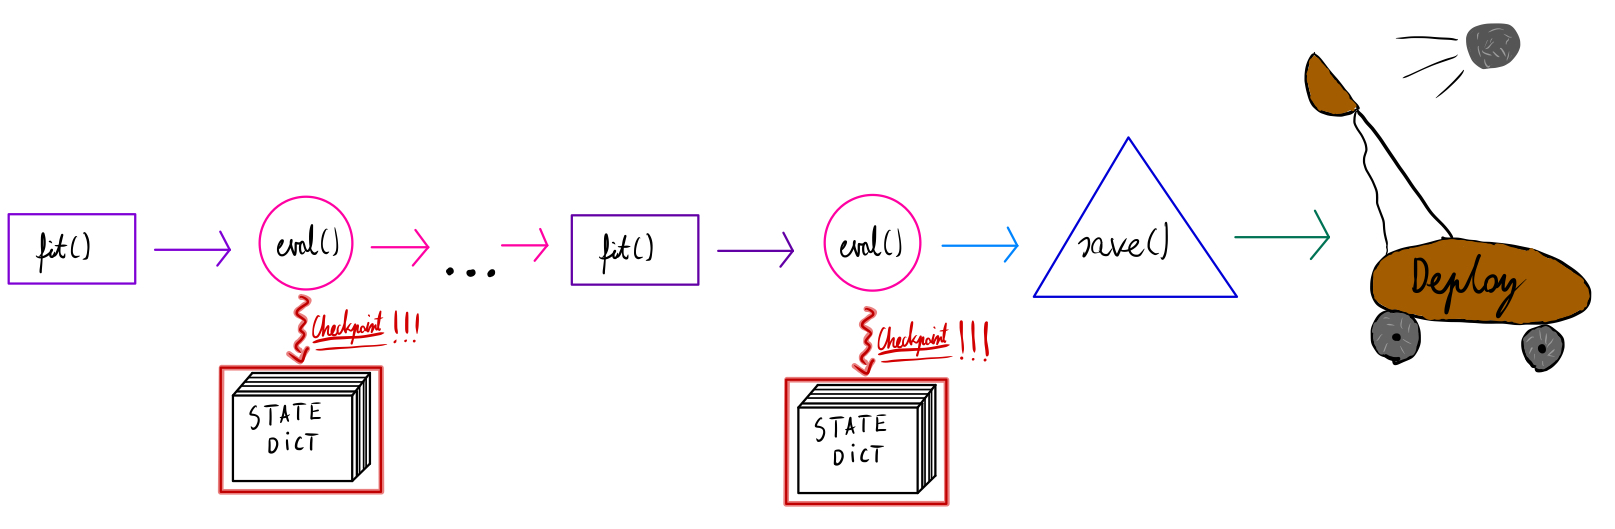

In [ ]:
# @title Saving and Loading the Checkpoints
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    """
    Save training state (model parameters, optimizer state, epoch, etc.) to disk.

    Parameters:
        state (dict):
            Contains keys like:
              - "state_dict": model.state_dict()
              - "optimizer": optimizer.state_dict()
              - any other metadata (e.g., epoch, loss)
        filename (str):
            Path where the checkpoint file will be written (default: "my_checkpoint.pth.tar").
    """

    print("=> Saving checkpoint")            # notify user
    torch.save(state, filename)              # torch.save serializes the entire state dict


def load_checkpoint(checkpoint, model, optimizer):
    """
    Load model and optimizer state from a checkpoint dictionary.

    Parameters:
        checkpoint (dict):
            Loaded checkpoint, typically from torch.load(filename), containing:
              - "state_dict": saved model parameters
              - "optimizer": saved optimizer state
        model (nn.Module):
            The model instance into which weights will be loaded.
        optimizer (Optimizer):
            The optimizer instance whose state (e.g., learning rate, momentum buffers)
            will be restored.
    """

    print("=> Loading checkpoint")           # notify user
    model.load_state_dict(checkpoint["state_dict"])    # load saved weights into model
    optimizer.load_state_dict(checkpoint["optimizer"]) # restore optimizer parameters

---

#Architecture

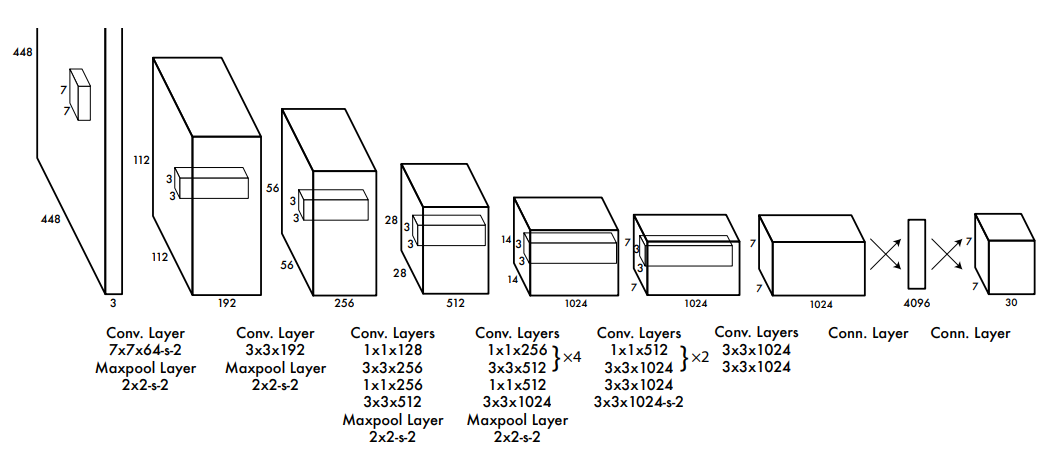

source: Redmon et al., “You Only Look Once: Unified, Real-Time Object Detection”

In [ ]:
architecture_config = [
  # Tuple: (kernel_size, num_filters, stride, padding)
  (7, 64, 2, 3),    # Conv7x7 → 64 filters, stride 2, pad 3
  'M',              # MaxPool 2x2, stride 2

  (3, 192, 1, 1),   # Conv3x3 → 192 filters, stride 1, pad 1
  'M',              # MaxPool -||-

  (1, 128, 1, 0),   # Conv1x1 → 128 filters, stride 1, pad 0
  (3, 256, 1, 1),   # Conv3x3 → 256 filters, stride 1, pad 1
  (1, 256, 1, 0),   # Conv1x1 → 256 filters, stride 1, pad 0
  (3, 512, 1, 1),   # Conv3x3 → 512 filters, stride 1, pad 1
  'M',              # MaxPool -||-

  # List: (conv1 params, conv2 params, repeat count)
  [(1, 256, 1, 0), (3, 512, 1, 1), 4],  # repeat 1×1 → 3×3 block 4 times
  (1, 512, 1, 0),   # Conv1x1 → 512 filters
  (3, 1024, 1, 1),  # Conv3x3 → 1024 filters
  'M',              # MaxPool -||-

  [(1, 512, 1, 0), (3, 1024, 1, 1), 2], # repeat 1×1 → 3×3 block 2 times
  (3, 1024, 1, 1),  # Conv3x3 → 1024 filters
  (3, 1024, 2, 1),  # Conv3x3 → 1024 filters, stride 2 (downsample)

  (3, 1024, 1, 1),  # Conv3x3 → 1024 filters
  (3, 1024, 1, 1),  # Conv3x3 → 1024 filters
]

In [ ]:
# @title Convolutional Block (Conv2d → BatchNorm → GELU)
class CNN_block(nn.Module):
	"""
	CNN block combining convolution, batch normalization, and activation.

	Parameters:
		in_channels (int):
			Number of channels in the input tensor.
		out_channels (int):
			Number of channels produced by the convolution.
		**kwargs:
			Additional kwargs for nn.Conv2d, e.g., kernel_size, stride, padding.

	Returns:
		torch.Tensor:
			Activated feature map of shape (batch_size, out_channels, H_out, W_out).
	"""

	def __init__(self, in_channels, out_channels, **kwargs):
		super().__init__()

		self.Conv = nn.Conv2d(
			in_channels=in_channels,
			out_channels=out_channels,
			bias=False,  # because we use BN which subtracts the mean and removes bias (NOT in original YOLOv1)
			**kwargs
		)
		self.BN = nn.BatchNorm2d(out_channels)  # ORIGINAL PAPER DIDN'T USE BN (added here for stability)

	def forward(self, X):
		out = self.Conv(X)    # apply 2D convolution
		out = self.BN(out)    # normalize each output channel
		out = F.gelu(out)     # activation (original used LeakyReLU)
		return out            # return the processed feature map

In [ ]:
# @title YOLOv1 Model Definition
class YOLOv1(nn.Module):
  """
  YOLO v1 detector: Darknet‐style conv backbone + FC detection head.

  Parameters:
      in_channels (int):       Number of input channels (e.g., 3 for RGB).
      arch_config (list):      Architecture spec list (tuples, 'M', or [tuple,tuple,repeats]).
      **kwargs:                split_size (int), num_boxes (int), num_classes (int)

  Returns:
      torch.Tensor:            Raw predictions of shape (batch, S*S*(C + 5*B)).
  """

  def __init__(self, in_channels=3, arch_config=architecture_config, **kwargs):
   super().__init__()

   self.architecture_config = arch_config
   self.in_channels = in_channels
   # build convolutional backbone using the architecture config
   self.darknet = self._create_conv_layers(self.architecture_config)

   # build the FC detection head:
   # outputs S*S*(num_classes + 5*num_boxes) values per image
   self.fc = self._create_fcs(**kwargs)


  def _create_conv_layers(self, architecture_config):
    """
    Parse arch_config entries:
      - tuple → one CNN_block
      - 'M'    → MaxPool2d
      - list   → repeat a pair of CNN_blocks
    """
    layers = []

    in_channels = self.in_channels  # track current channel count

    for layer in architecture_config:
      if type(layer) == tuple:
        # unpack tuple: (kernel_size, num_filters, stride, padding)
        layers += [CNN_block(in_channels=in_channels,
                             out_channels=layer[1],
                             kernel_size=layer[0],
                             stride=layer[2],
                             padding=layer[3])]
        in_channels = layer[1]  # update channel count

      elif type(layer) == str:
        # 'M' → downsample spatial dims by 2
        layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=2)]

      else:
        # list: [(k1, f1, s1, p1), (k2, f2, s2, p2), repeats]
        conv1 = layer[0]
        conv2 = layer[1]
        num_repeats = layer[2]

        for _ in range(num_repeats):
          # 1×1 bottleneck conv
          layers += [CNN_block(in_channels=in_channels,
                               out_channels=conv1[1],
                               kernel_size=conv1[0],
                               stride=conv1[2],
                               padding=conv1[3])]
          # 3×3 expansion conv
          layers += [CNN_block(in_channels=conv1[1],
                               out_channels=conv2[1],
                               kernel_size=conv2[0],
                               stride=conv2[2],
                               padding=conv2[3])]
          in_channels = conv2[1]  # update channels after each block

    return nn.Sequential(*layers)  # wrap into Sequential for forward pass

  # IF YOU WANT FASTER RESULTS, reduce split_size, num_boxes, or num_classes
  def _create_fcs(self, split_size, num_boxes, num_classes):
    """
    Build the fully connected head:
      Flatten → Linear(1024*S*S→4096) → GELU → Dropout → Linear(4096→S*S*(C+5B))
    """
    fcs = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024 * split_size * split_size, 4096),
        nn.GELU(),                 # activation (original used LeakyReLU)
        nn.Dropout(0.5),           # regularization
        nn.Linear(4096, split_size * split_size * (num_classes + 5 * num_boxes))
    )
    return fcs


  def forward(self, X):
    """
    Forward pass:
      1. Extract features via darknet → shape (batch, 1024, S, S)
      2. Flatten to (batch, 1024*S*S)
      3. Apply FC detection head → raw predictions
    """
    out = self.darknet(X)                     # conv backbone
    out = torch.flatten(out, start_dim=1)     # flatten spatial dims
    out = self.fc(out)                        # detection predictions
    return out

#Loss

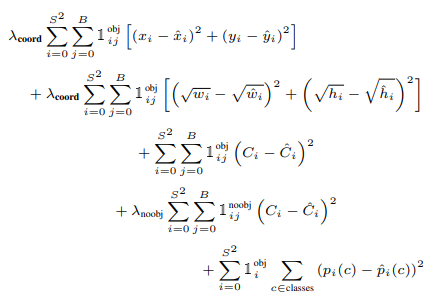

source: Redmon et al., “You Only Look Once: Unified, Real-Time Object Detection”

In [ ]:
# @title YOLO Loss Function
class YOLO_Loss(nn.Module):
  """
  YOLO v1 loss: coordinate + objectness + no-objectness + classification.

  Parameters:
      split_size (int):   Number of grid cells per side (S).
      num_bboxes (int):   Number of boxes predicted per cell (B).
      num_classes (int):  Number of object classes (C).

  Forward Inputs:
      preds (Tensor): model output of shape (N, S*S*(C + 5*B)) or reshaped to (N, S, S, C+5B).
      target (Tensor): ground truth tensor, same shape as preds.

  Returns:
      torch.Tensor: Scalar loss combining all components, ready for backprop.
  """

  def __init__(self, split_size=7, num_bboxes=2, num_classes=20):
    super().__init__()

    self.MSE = nn.MSELoss(reduction='sum')

    self.S = split_size
    self.B = num_bboxes
    self.C = num_classes

    # Weighting factors from the original YOLO v1 paper:
    # λ_coord = 5 → amplifies coordinate error so the model focuses on localization accuracy.
    self.lambda_coord = 5

    # λ_noobj = 0.5 → down-weights loss for predicting objects in background cells,
    # prevents the enormous number of empty cells from dominating training.
    self.lambda_noobj = 0.5

  def forward(self, preds, target):
    preds = preds.reshape(-1, self.S, self.S, self.C + 5 * self.B)

    iou_b1 = intersection_over_union(preds[..., self.C+1 : self.C+1+4],  # box1 coords
                                     target[..., self.C+1 : self.C+1+4])

    iou_b2 = intersection_over_union(preds[..., self.C+1+5 : self.C+1+4+5],  # box2 coords
                                     target[..., self.C+1 : self.C+1+4])

    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
    best_box = torch.argmax(ious, dim=0)

    exists_box = target[..., 20].unsqueeze(3)  # 1 if object exists in cell, else 0


    #============================#
    #  LOSS FOR BOX COORDINATES  #
    #============================#

    # Select only the chosen box’s (x, y, w, h) predictions,
    # and ignore cells without objects via exists_box mask.
    box_preds = exists_box * (
      best_box * preds[..., 26:30] +
      (1 - best_box) * preds[..., 21:25]
    )
    box_targets = exists_box * target[..., 21:25]

    # Take square root of width/height to reduce error emphasis on large boxes.
    # Add epsilon to avoid infinite gradients at zero.
    box_preds[..., 2:4] = torch.sign(box_preds[..., 2:4]) * torch.sqrt(
      torch.abs(box_preds[..., 2:4] + 1e-8)
    )
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

    # Flatten from (N, S, S, 4) to (N*S*S, 4) before applying MSE.
    box_loss = self.MSE(
      torch.flatten(box_preds,   end_dim=-2),
      torch.flatten(box_targets, end_dim=-2)
    )


    #=========================#
    #   LOSS FOR OBJECTNESS   #
    #=========================#

    # Use the confidence of the best box for each cell.
    pred_box = (
      best_box * preds[..., 25:26] +
      (1 - best_box) * preds[..., 20:21]
    )
    object_loss = self.MSE(
      torch.flatten(exists_box * pred_box,           start_dim=1),
      torch.flatten(exists_box * target[..., 20:21], start_dim=1)
    )


    #==========================#
    #  LOSS FOR NO-OBJECTNESS  #
    #==========================#

    # Penalize confidence where no object should be present.
    no_object_loss = self.MSE(
      torch.flatten((1 - exists_box) * preds[..., 20:21], start_dim=1),
      torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
    )
    # Include second predictor’s confidence in background cells.
    no_object_loss += self.MSE(
      torch.flatten((1 - exists_box) * preds[..., 25:26], start_dim=1),
      torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
    )


    #=============================#
    #   LOSS FOR CLASSIFICATION   #
    #=============================#

    # Compute classification loss only in cells containing objects.
    class_loss = self.MSE(
      torch.flatten(exists_box * preds[..., :self.C],   end_dim=-2),
      torch.flatten(exists_box * target[..., :self.C], end_dim=-2)
    )


    #=====================#
    #     TOTAL LOSS      #
    #=====================#

    # λ_coord * box_loss → emphasizes localization
    # + object_loss    → confidence when object exists
    # + λ_noobj * no_object_loss → down-weight background penalties
    # + class_loss     → classification error
    loss = (
      self.lambda_coord * box_loss +
      object_loss +
      self.lambda_noobj * no_object_loss +
      class_loss
    )

    return loss

#Data Configuration

In [ ]:
class VOC_Dataset(Dataset):
  """
  PyTorch Dataset for Pascal VOC–style labels, converting them into YOLO’s S×S grid format.

  Parameters:
      csv_file (str): Path to a CSV where each row is [image_filename, label_filename].
      img_dir (str): Directory with the image files.
      label_dir (str): Directory with the label .txt files.
      S (int): Grid size per axis (default 7 → 7×7 grid).
      B (int): Number of boxes predicted per cell (default 2).
      C (int): Number of object classes (default 20).
      transform (callable, optional): Augmentation function(image, boxes) → (image, boxes).

  Returns (from __getitem__):
      image: the PIL image (or transformed tensor).
      label_matrix: Tensor of shape (S, S, C + 5*B), where for each cell [i,j]:
          - [0:C)     one-hot class vector
          - [C]       object-present flag (0 or 1)
          - [C+1:C+5] bounding box coords (x_cell, y_cell, w_cell, h_cell)
  """
  def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
    # load the CSV mapping image → label filenames
    self.annotations = pd.read_csv(csv_file)
    # directory containing the images
    self.img_dir = img_dir
    # directory containing the label text files
    self.label_dir = label_dir
    # optional transform applied to image and boxes
    self.transform = transform

    # grid division size (cells per side)
    self.S = S
    # number of predicted boxes per cell (used to size the label depth)
    self.B = B
    # total number of object classes
    self.C = C

  def __len__(self):
    # return total number of samples (rows in the CSV)
    return len(self.annotations)

  def __getitem__(self, idx):
    # 1) build path to this sample’s label .txt
    label_path = os.path.join(self.label_dir, self.annotations.iloc[idx, 1])

    boxes = []  # will collect all ground-truth boxes for this image

    # 2) read each line in the label file
    with open(label_path) as f:
      for label in f.readlines():
        # parse "class_label x_center y_center width height"
        class_label, x, y, width, height = [
            float(x) if float(x) != int(float(x)) else int(x)
            for x in label.replace('\n', '').split()
        ]
        # append as [class, x, y, w, h]
        boxes.append([class_label, x, y, width, height])

    # 3) load the corresponding image
    img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
    image = Image.open(img_path)

    # 4) convert boxes list into tensor (num_boxes, 5)
    boxes = torch.tensor(boxes)

    # 5) apply optional transforms (e.g., augmentation)
    if self.transform:
      image, boxes = self.transform(image, boxes)

    # 6) initialize the YOLO label matrix of zeros
    #    shape = (S, S, C + 5*B)
    label_matrix = torch.zeros((self.S, self.S, self.C + (5 * self.B)))

    # 7) populate one grid cell per ground-truth box
    for box in boxes:
      class_label, x, y, width, height = box.tolist()
      class_label = int(class_label)  # cast class index to int

      # compute cell row i and column j for the box center
      i, j = int(self.S * y), int(self.S * x)

      # compute box coordinates relative to cell top-left
      x_cell = self.S * x - j       # fractional x offset within cell
      y_cell = self.S * y - i       # fractional y offset within cell
      width_cell = width * self.S   # width in cell units
      height_cell = height * self.S # height in cell units

      # only assign if this cell has not yet been marked
      if label_matrix[i, j, 20] == 0:
        # mark presence of an object in this cell
        label_matrix[i, j, 20] = 1

        # store relative box coords in indices 21–24
        box_cordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
        label_matrix[i, j, 21:25] = box_cordinates

        # one-hot encode class in indices [0:C)
        label_matrix[i, j, class_label] = 1

    # 8) return the (possibly transformed) image and its label matrix
    return image, label_matrix

##Data Augmentation

In the original paper they used more / different data augmentation, but it would take weeks if we use the one the autors have used. If you want to read all of the augmentations please read the last paragraph of '2.2 Training' in the paper

In [ ]:
class Compose(object):
  """
  Chains a sequence of transforms to be applied to an image (and optionally its bounding boxes).

  Parameters:
      transforms (list of callables):
          Each element is either:
            - a function transform(img, boxes) → (img, boxes), for transforms that adjust both image and boxes, or
            - a function transform(img) → img, for image-only transforms.

  Returns (when called):
      img:   the transformed image after applying all transforms in sequence
      boxes: the transformed bounding boxes (unchanged by image-only transforms)
  """
  def __init__(self, transforms):
    self.transforms = transforms   # store the list of transform functions

  def __call__(self, img, bboxes):
    boxes = bboxes                 # make a working copy of the box list/tensor
    for transform in self.transforms:
      try:
        # try applying a transform that expects both image and boxes
        img, boxes = transform(img, boxes)
      except TypeError:
        # if it fails, assume this is an image-only transform
        img = transform(img)
    return img, boxes              # return the final image and box set

In [ ]:
# Define transforms for training data:
# - Resize all images to 448×448 pixels
# - Randomly jitter brightness and contrast by up to ±10%
# - Convert PIL Image to PyTorch tensor (scales pixels to [0,1])
# - Normalize channels using ImageNet mean/std (centers & scales)
train_transform = Compose([
    transforms.Resize((448, 448)),                              # resize to (H, W) = (448, 448)
    transforms.ColorJitter(brightness=0.1, contrast=0.1),       # random brightness/contrast shifts
    transforms.ToTensor(),                                     # PIL → tensor, scale 0–255 → 0–1
    transforms.Normalize(                                       # channel-wise normalization
        mean=[0.485, 0.456, 0.406],  # ImageNet dataset channel means (R, G, B)
        std=[0.229, 0.224, 0.225]    # ImageNet dataset channel standard deviations (R, G, B)
    )
])

# Define transforms for validation/testing data:
# - Resize to 448×448
# - Convert to tensor
# - Normalize with same mean/std (no random jitter)
test_transform = Compose([
    transforms.Resize((448, 448)),                              # resize to network input size
    transforms.ToTensor(),                                     # convert to tensor
    transforms.Normalize(                                       # apply same normalization
        mean=[0.485, 0.456, 0.406],  # ImageNet channel means
        std=[0.229, 0.224, 0.225]    # ImageNet channel standard deviations
    )
])

##Creating Train and Test Datasets

In [ ]:
IMG_DIR = '/content/YOLOv1_Dataset/pascalvoc-yolo/images'
LABEL_DIR = '/content/YOLOv1_Dataset/pascalvoc-yolo/labels'

In [ ]:
# create the training dataset: reads train.csv, loads images/labels, applies train_transform
train_dataset = VOC_Dataset(
    '/content/YOLOv1_Dataset/pascalvoc-yolo/train.csv',
    IMG_DIR,
    LABEL_DIR,
    transform=train_transform
)

# create the validation/test dataset: reads test.csv, loads images/labels, applies test_transform
test_dataset = VOC_Dataset(
    '/content/YOLOv1_Dataset/pascalvoc-yolo/test.csv',
    IMG_DIR,
    LABEL_DIR,
    transform=test_transform
)

##Creating Train and Test Dataloaders

In [ ]:
# number of samples per batch (how many images processed before updating weights)
BATCH_SIZE = 64

# number of worker processes loading data in parallel
NUM_WORKERS = 2

# if True, the DataLoader will copy Tensors into CUDA pinned memory before returning them,
# which can accelerate host→device transfers when using a GPU
PIN_MEMORY = True

In [ ]:
# Create DataLoader for training:
# - drop_last=True ensures the final, smaller-than-BATCH_SIZE batch is discarded,
#   because very small batches can lead to unstable gradient updates (this only happends if data_num % batch_size != 0).
train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,    # number of samples per gradient update
    num_workers=NUM_WORKERS,  # parallel data-loading workers
    pin_memory=PIN_MEMORY,    # speed up GPU transfers by using pinned (page-locked) memory
    shuffle=False,            # whether to shuffle data each epoch
    drop_last=True            # drop final incomplete batch to avoid tiny-batch gradient issues
)

# Create DataLoader for validation/testing:
# - drop_last=False keeps all samples, even if the final batch is smaller.
test_dl = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
    drop_last=False           # keep the last smaller batch for full evaluation coverage
)

#Training

In [ ]:
# @title #### Training Hyperparameters

# random seed for reproducibility (ensures same weight initialization, shuffling, etc.)
seed = 24

# ---- Quick‐run settings (reduce epochs/LR for faster iteration) ----
LR = 2e-5            # learning rate for the optimizer
WEIGHT_DECAY = 1e-4  # L2 regularization strength (penalizes large weights)
EPOCHS = 12          # total number of training passes over the dataset

# ---- Original YOLO v1 paper settings ----
"""
NUM_EPOCHS = 135           # paper: total epochs
BATCH_SIZE = 64            # paper: batch size per update
INITIAL_LR = 1e-3         # paper: starting learning rate
LR_DECAY_EPOCH = 75        # epoch at which to reduce LR
MOMENTUM = 0.9             # SGD momentum factor
WEIGHT_DECAY = 5e-4      # paper: L2 regularization strength

optimizer = optim.SGD(
    model.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[LR_DECAY_EPOCH],
    gamma=0.1  # multiply LR by 0.1 at the milestone
)
"""

SHOW_TRAIN_BATCH_PICS = 25 # if number of train batch is devisable by 25 -> show the predicted outputs on random img
SHOW_TEST_BATCH_PICS = 5 # if number of test batch is devisable by 25 -> show the predicted outputs on random img
# control saving/loading of model checkpoints
SAVE_MODEL = False            # if True, save model after training ends
LOAD_MODEL = False            # if True, load a checkpoint before training
LOAD_MODEL_FILE = 'YOLOv1.pth'  # filename for loading/saving checkpoints

In [ ]:
CLASS_NAMES = ['aeroplane',
               'bicycle',
               'bird',
               'boat',
               'bottle',
               'bus',
               'car',
               'cat',
               'chair',
               'cow',
               'diningtable',
               'dog',
               'horse',
               'motorbike',
               'person',
               'pottedplant',
               'sheep',
               'sofa',
               'train',
               'tvmonitor'] # All of the objects (classes) that we want to detect (are in Pascal VOC dataset)

In [ ]:
torch.manual_seed(seed)

In [ ]:
# @title ### Training Function
def train_fn(train_loader, model, optimizer, loss_fn):
  """
  Runs one training epoch over the provided data.

  Parameters:
      train_loader (DataLoader): Iterable over batches of (inputs, targets).
      model (nn.Module): The neural network being trained.
      optimizer (Optimizer): Optimizer for updating model parameters.
      loss_fn (callable): Loss function accepting (predictions, targets) → scalar tensor.

  Returns:
      float: Average loss across all batches in this epoch.
  """

  model.train()               # set model to training mode (enables dropout, updates batchnorm which we use)

  mean_loss = []              # list to accumulate batch losses

  for batch, (X, y) in enumerate(train_loader):
    # move inputs and labels to the correct device (CPU/GPU)
    X, y = X.to(device), y.to(device)

    # forward pass: compute predictions
    y_pred = model(X)

    # compute loss for this batch
    loss = loss_fn(y_pred, y)
    mean_loss.append(loss.item())  # record scalar loss value

    # backpropagation and parameter update
    optimizer.zero_grad()    # reset gradients from previous step
    loss.backward()          # compute gradients
    optimizer.step()         # apply gradients to update weights

  # return the mean loss over all batches
  return sum(mean_loss) / len(mean_loss)

In [ ]:
model = YOLOv1(split_size=7, num_boxes=2, num_classes=20).to(device) # initialize the model and save it to the device

In [ ]:
#OPTIONAL
if LOAD_MODEL:
  # load model & optimizer state from checkpoint before training
  load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # AdamW optimizer: decouples weight decay from gradient updates (original paper used SGD)
loss_fn = YOLO_Loss()  # custom YOLO v1 loss combining coordinate, objectness, no-objectness, and classification terms

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)  # reduce LR by factor 0.2 every 4 epochs (original paper used MultiStepLR)

In [ ]:
# @title Training Loop
for epoch in tqdm(range(EPOCHS)):
	# 1) Extract predicted and ground-truth boxes and the corresponding classes from the model on the entire training set
	pred_boxes, target_boxes = get_bboxes(
		train_dl, model, iou_threshold=0.5, threshold=0.4
	)

	# 2) Compute mean Average Precision (mAP) at IoU=0.5
	mAP = mean_average_precision(
		pred_boxes, target_boxes, iou_threshold=0.5
	)

	# 3) Optional early‐stopping & checkpointing
	if SAVE_MODEL:
		if mAP >= 0.6:  # if target performance is reached
			checkpoint = {
				'MODEL_state_dict': model.state_dict(),
				'OPTIMIZER_state_dict': optimizer.state_dict()
			}
			save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
			print(f"\n⚠️ Early stopping: mAP reached {mAP:.2f} at epoch {epoch+1} ⚠️")
			break  # exit training loop

	# 4) Train for one epoch and get the average loss
	mean_loss = train_fn(train_dl, model, optimizer, loss_fn)

	# 5) Update the learning rate according to the scheduler
	lr_scheduler.step()

	# 6) Print epoch summary
	print(f'=================\nEpoch: {epoch + 1}\n=================')
	print(f'Train mAP: {mAP:.2f}')
	print(f'Mean Loss is: {mean_loss:.4f}\n')

In [ ]:
#OPTIONAL
if SAVE_MODEL:
  # save model & optimizer state for checkpoint after training
  torch.save({
          'MODEL_state_dict': model.state_dict(),
          'OPTIMIZER_state_dict': optimizer.state_dict()
          }, 'YOLO_V1_state_dict.pth')

In [ ]:
model.eval()  # switch to evaluation mode (disables dropout, uses running stats)

for num_train_dl, (X, y) in enumerate(train_dl):
	X = X.to(device)  # move batch to the selected device
	if num_train_dl % SHOW_TRAIN_BATCH_PICS == 0:  # every N batches, show a sample
		for idx in range(X.size(0)):
			idx = int(random.uniform(0, BATCH_SIZE))  # pick a random index within the batch by truncating a uniform float in [0, BATCH_SIZE)
			bboxes = cellboxes_to_boxes(model(X))  # run model on entire batch and convert raw output to per-image bbox lists
			bboxes = non_max_suppression(
				bboxes[idx],                # select boxes for the randomly chosen image
				iou_threshold=0.5,          # IoU cutoff: remove highly overlapping boxes
				threshold=0.4,              # confidence cutoff: keep boxes with score > 0.4
				box_format="midpoint"       # coordinate format used for IoU and NMS
			)
			plot_image(                      # visualize the chosen image with predicted boxes
				X[idx].permute(1, 2, 0).to("cpu"),  # convert C×H×W tensor to H×W×C array for plotting (we do this beacause matplotlib expevt this type of format)
				bboxes,
				class_names=CLASS_NAMES             # overlay readable class labels
			)
			break  # only display one image per trigger

#Test

In [ ]:
# @title ###Testing Function
def test_fn(test_loader, model, loss_fn):
	model.eval()  # set model to evaluation mode (disables dropout, uses running stats)
	total_loss = 0.0  # sum of batch losses
	n_batches = 0     # number of batches processed

	with torch.no_grad():  # no gradients needed during evaluation
		for X, y in test_loader:  # iterate over test/validation DataLoader
			X, y = X.to(device), y.to(device)  # move inputs and labels to the device
			preds = model(X)  # forward pass: compute predictions
			total_loss += loss_fn(preds, y).item()  # compute loss and add its scalar value
			n_batches += 1  # increment batch count

	return total_loss / n_batches  # return average loss across all batches

In [ ]:
# @title Test Loop

pred_boxes, target_boxes = get_bboxes(
    test_dl, model, iou_threshold=0.5, threshold=0.4
)  # extract predicted and ground-truth boxes and the coresponding classes for every image in the test set

mean_loss = test_fn(test_dl, model, loss_fn)  # compute average loss over all test batches

mAP = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0.5
)  # calculate mean Average Precision at IoU=0.5 on the test set

print(f'Test mAP: {mAP:.2f}')               # print the test set mAP
print(f'Mean Loss is: {mean_loss:.4f}\n')  # print the average test loss

In [ ]:
model.eval()  # switch to evaluation mode (disables dropout, uses running stats)

for num_test_dl, (X, y) in enumerate(test_dl):
	X = X.to(device)  # move batch to the selected device
	if num_test_dl % SHOW_TEST_BATCH_PICS == 0:  # every N batches, trigger visualization
		for idx in range(X.size(0)):
			idx = int(random.uniform(0, BATCH_SIZE))  # pick a random float in [0, BATCH_SIZE], then truncate to int (0 ≤ idx < BATCH_SIZE)
			bboxes = cellboxes_to_boxes(model(X))  # convert raw network output to per-image box lists
			bboxes = non_max_suppression(
				bboxes[idx],                # select boxes for the chosen image
				iou_threshold=0.5,          # IoU cutoff to suppress overlapping boxes
				threshold=0.4,              # confidence cutoff; keep only boxes above this score
				box_format="midpoint"       # coordinate format for IoU/NMS calculations
			)
			plot_image(
				X[idx].permute(1,2,0).to("cpu"),  # convert C×H×W tensor to H×W×C PIL‐style image
				bboxes,
				class_names=CLASS_NAMES          # overlay human-readable class labels
			)
			break  # show only one example per trigger